# MP2 - Scale-Space Blob Detection

## Jiaxi Nie (nie9)

In [25]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color, transform
from scipy.ndimage.filters import gaussian_laplace, generic_filter, gaussian_filter
from numpy.random import rand, randint

In [26]:
Scale = 2
k = 1.3
Level = 12
NMS_size = 3

In [38]:
def NMS(Array):
    '''
    center_idx = int(NMS_3D_size / 2)
    center_val = Array[center_idx]
    if center_val == Array.max() and center_val > Array[center_idx-NMS_2D_size] and center_val > Array[center_idx+NMS_2D_size]:
        return center_val
    else:
        return 0
    '''
    center_val = Array[int(NMS_3D_size / 2)]
    ret = center_val if center_val == Array.max() else 0
    return ret

In [28]:
def show_all_circles(image, cx, cy, rad, img_name, Approach, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    out_name = "Approach" + str(Approach) + "_" + img_name
    plt.savefig(out_name)
    plt.show()

 Approach 1: increase filter size

In [29]:
def Inc_Filt_Size(gray_img):
    scale_space = np.empty((h, w, Level))
    for n in range(Level):
        sigma = Scale * k ** n
        #print("n =", n, " sigma =", sigma)
        scale_space[:, :, n] = ((sigma ** 2) * gaussian_laplace(gray_img, sigma=sigma)) ** 2
    NMS_out = generic_filter(scale_space, NMS, footprint=np.ones((NMS_size, NMS_size, 3)))
    return NMS_out
    

 Approach 2: downsample the image

In [30]:
def Downsample(gray_img):
    scale_space = np.empty((h, w, Level))
    for n in range(Level):
        cur_scale = k ** n
        scaled_img = transform.resize(gray_img, (int(h/cur_scale), int(w/cur_scale)))
        squared_lap = (gaussian_laplace(scaled_img, sigma=Scale)) ** 2
        scale_space[:, :, n] = transform.resize(squared_lap, (h, w))
    NMS_out = generic_filter(scale_space, NMS, footprint=np.ones((NMS_size, NMS_size, 3)))
    return NMS_out


Approach 3: Difference of Gaussian

In [31]:
def DoG(gray_img, numOctave, numScaleImg, numDiffImg):
    """ 
    3 octaves, 5 images to be filters in each octave to produce 4 difference images
    """
    k = 2 ** (1 / numDiffImg)
    diff_space = np.empty((h, w, numOctave*numDiffImg)) 
    
    # first octave
    scale_space = np.empty((h, w, numScaleImg))
    for n in range(numScaleImg):
        sigma = Scale * k ** n
        scale_space[:, :, n] = gaussian_filter(gray_img, sigma=sigma)
        if n > 0:
            diff_space[:, :, n-1] = (scale_space[:, :, n] - scale_space[:, :, n-1]) ** 2
    
    # second octave
    h2, w2 = int(h/2), int(w/2)
    scale_space = np.empty((h2, w2, numScaleImg))
    scaled_img = transform.resize(gray_img, (h2, w2))
    for n in range(numScaleImg):
        sigma = 2 * Scale * k ** n
        scale_space[:, :, n] = gaussian_filter(scaled_img, sigma=sigma)
        if n > 0:
            squared_diff = (scale_space[:, :, n] - scale_space[:, :, n-1]) ** 2   
            diff_space[:, :, n-1+numDiffImg] = transform.resize(squared_diff, (h, w))
    
    # third octave
    h3, w3 = int(h/4), int(w/4)
    scale_space = np.empty((h3, w3, numScaleImg))
    scaled_img = transform.resize(gray_img, (h3, w3))
    for n in range(numScaleImg):
        sigma = 4 * Scale * k ** n
        scale_space[:, :, n] = gaussian_filter(scaled_img, sigma=sigma)
        if n > 0:
            squared_diff = (scale_space[:, :, n] - scale_space[:, :, n-1]) ** 2   
            diff_space[:, :, n-1+2*numDiffImg] = transform.resize(squared_diff, (h, w))
            
    NMS_out = generic_filter(diff_space, NMS, footprint=np.ones((NMS_size, NMS_size, 3)))
    return NMS_out
    

Approach 4: Filtering with Harris Response

In [32]:
def calc_Harris_Response(img, sigma):
    # compute gradient
    ix, iy = np.zeros(img.shape), np.zeros(img.shape)
    ix = gaussian_filter(img, (sigma, sigma), (0, 1))   # (h, w)
    iy = gaussian_filter(img, (sigma, sigma), (1, 0))
                                                                                    
    # compute Second Moment Matrix M
    Wxx = gaussian_filter (ix*ix, sigma)    # (h, w)
    Wxy = gaussian_filter (ix*iy, sigma) 
    Wyy = gaussian_filter (iy*iy, sigma)
    
    # determinant and trace 
    alpha = 0.05
    Wdet = Wxx * Wyy - Wxy ** 2 
    Wtr = Wxx + Wyy
    R = Wdet - alpha * Wtr ** 2

    #print(R.shape)
    return R
    

In [33]:
def Harris_Filt(img, NMS_out):
    Harris_out = np.empty((NMS_out.shape))
    for n in range(Level):
        sigma = Scale * k ** n
        R = calc_Harris_Response(img, sigma)
        pos_R_idx = np.where(R>0)
        mask = np.zeros(img.shape)
        mask[pos_R_idx] = 1
        Harris_out[:, :, n] = np.multiply(NMS_out[:, :, n], mask)
    return Harris_out


Approach 5: Affine Adaptation

In [23]:
def Find_Eigval(img, sigma):
    # compute gradient
    ix, iy = np.zeros(img.shape), np.zeros(img.shape)
    ix = gaussian_filter(img, (sigma, sigma), (0, 1))   # (h, w)
    iy = gaussian_filter(img, (sigma, sigma), (1, 0))
                                                                                    
    # compute Second Moment Matrix M
    Wxx = gaussian_filter (ix*ix, sigma)      # (h, w)
    Wxy = gaussian_filter (ix*iy, sigma) 
    Wyy = gaussian_filter (iy*iy, sigma)
    
    H, W = img.shape[0], img.shape[1]
    Eigval = np.zeros((H, W, 2))
    for y in H:
        for x in W:
            M = np.asarray([[Wxx[y, x], Wxy[y, x]], [Wxy[y, x], Wyy[y, x]]])
            lambdas, _ = np.linalg.eig(M)
            assert lambdas.shape[0] == 2
            if lambdas.max() > 0 and lambdas.min() > 0:
                Eigval[y, x, 0] = lambdas.max()
                Eigval[y, x, 1] = lambdas.min()
            else:
                Eigval[y, x, :] = np.zeros((2))
    return Eigval
    

In [ ]:
def Affine_transform(img):
    scale_space = np.empty((h, w, Level))
    eigval = np.empty((h, w, Level))
    
    for n in range(Level):
        sigma = Scale * k ** n
        scale_space[:, :, n] = ((sigma ** 2) * gaussian_laplace(gray_img, sigma=sigma)) ** 2
        sigma = 2 * Scale * k ** n 
        eigval[:, :, n] = Find_Eigval(img, sigma)
    NMS_out = generic_filter(scale_space, NMS, footprint=np.ones((NMS_size, NMS_size, 3)))
    return eigval, NMS_out


In [34]:
def plot_result(NMS_out, Level, Threshold, img_name, Approach):
    """ 
    Find x & y coordinated of the center and corresponding radius in scale space
    """
    cy = np.empty(Level, dtype=object)
    cx = np.empty(Level, dtype=object)
    radius = np.empty(Level, dtype=object)
    
    for n in range(Level):
        sigma = Scale * k ** n
        cy[n], cx[n] = np.where(NMS_out[:, :, n] > Threshold)
        # print(cy[n].shape[0], "pts")
        radius[n] = np.sqrt(2) * sigma * np.ones(cy[n].shape)

    cy = np.concatenate(cy)
    cx = np.concatenate(cx)
    radius = np.concatenate(radius)
    show_all_circles(gray_img, cx, cy, radius, img_name, Approach, color='r')

In [35]:
def plot_result_DoG(NMS_out, Level, numOctave, numDiffImg, Threshold, img_name, Approach):
    """ 
    Find x & y coordinated of the center and corresponding radius in scale space
    """
    cy = np.empty(Level, dtype=object)
    cx = np.empty(Level, dtype=object)
    radius = np.empty(Level, dtype=object)
    k = 2 ** (1 / numDiffImg)
    
    for n in range(Level):
        octaveIdx = n // numOctave
        sigma = 2 ** octaveIdx * Scale * k ** n
        cy[n], cx[n] = np.where(NMS_out[:, :, n] > Threshold)
        radius[n] = np.sqrt(2) * sigma * np.ones(cy[n].shape)

    cy = np.concatenate(cy)
    cx = np.concatenate(cx)
    radius = np.concatenate(radius)
    show_all_circles(gray_img, cx, cy, radius, img_name, Approach, color='r')
    

In [36]:
ls

Approach1_butterfly.jpg     Approach4_1_butterfly.jpg
Approach1_einstein.jpg      Approach4_1_einstein.jpg
Approach1_fishes.jpg        Approach4_1_fishes.jpg
Approach1_sunflowers.jpg    Approach4_1_sunflowers.jpg
Approach2_butterfly.jpg     Approach4_2_butterfly.jpg
Approach2_einstein.jpg      Approach4_2_einstein.jpg
Approach2_fishes.jpg        Approach4_2_fishes.jpg
Approach2_sunflowers.jpg    Approach4_2_sunflowers.jpg
Approach3_butterfly.jpg     MP2.ipynb
Approach3_einstein.jpg      assignment2_images/
Approach3_fishes.jpg        assignment2_sample_output/
Approach3_sunflowers.jpg


sunflowers.jpg
(357, 328, 3)


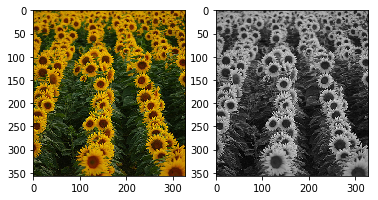

Approach 1: increase filter size, time = 5.430771350860596


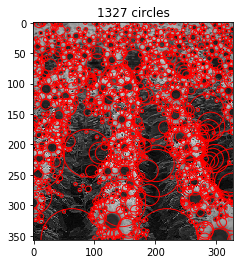

/Anaconda3/anaconda/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Approach 2: downsampling, time = 5.779818058013916


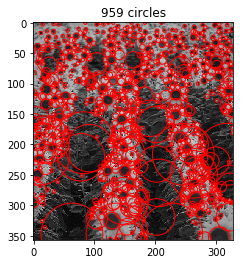

Approach 3: Difference of Gaussian, time = 4.10696816444397


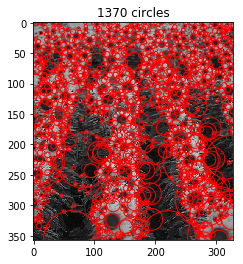

Approach 4: increase filter size with Harris filtering, time = 1.0681431293487549


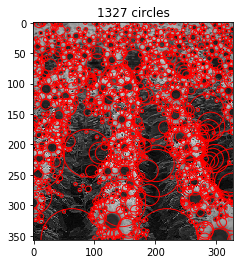

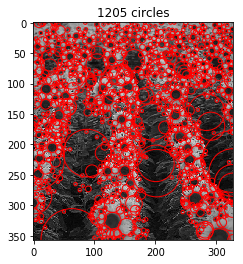

fishes.jpg
(335, 500, 3)


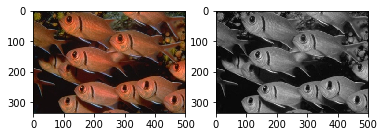

Approach 1: increase filter size, time = 9.909088850021362


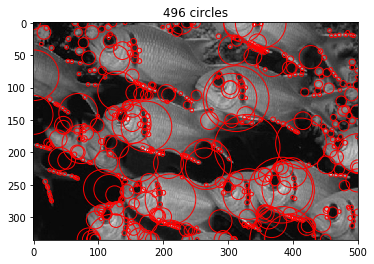

Approach 2: downsampling, time = 7.477335214614868


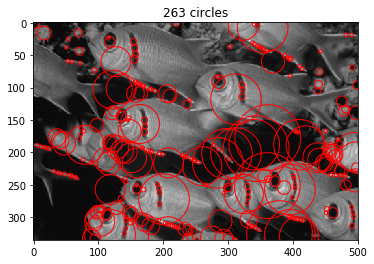

Approach 3: Difference of Gaussian, time = 5.4848408699035645


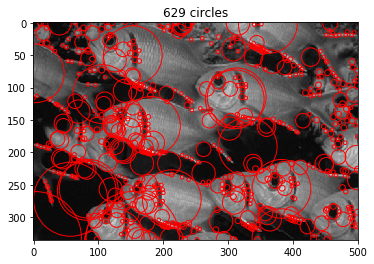

Approach 4: increase filter size with Harris filtering, time = 1.7177460193634033


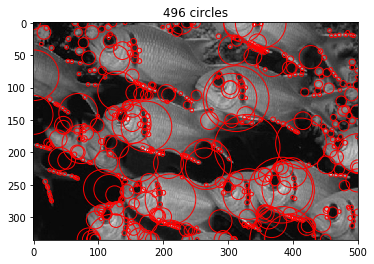

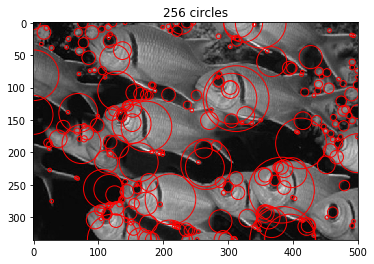

einstein.jpg
(480, 640, 3)


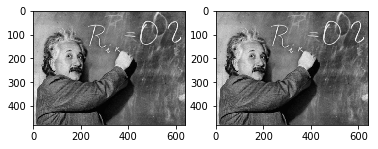

Approach 1: increase filter size, time = 17.801363229751587


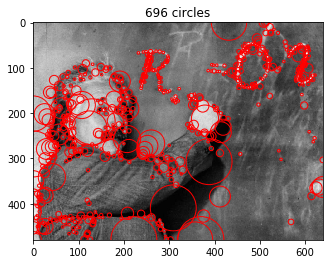

Approach 2: downsampling, time = 13.067909955978394


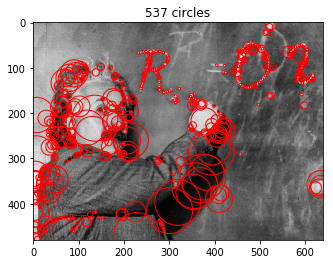

Approach 3: Difference of Gaussian, time = 9.689282178878784


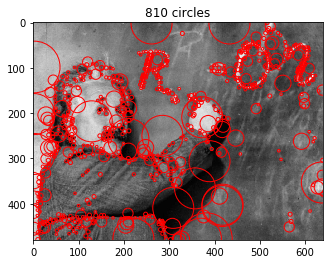

Approach 4: increase filter size with Harris filtering, time = 2.6899168491363525


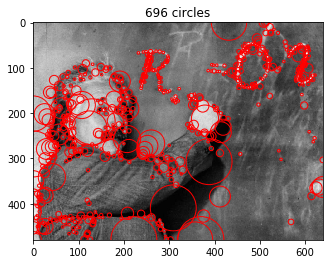

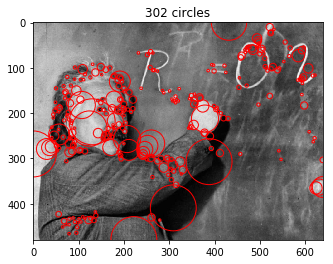

butterfly.jpg
(356, 493, 3)


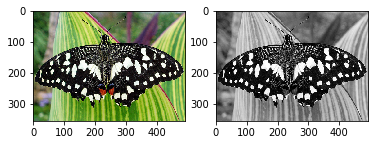

Approach 1: increase filter size, time = 7.814010143280029


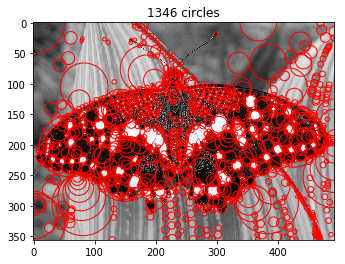

Approach 2: downsampling, time = 7.483482122421265


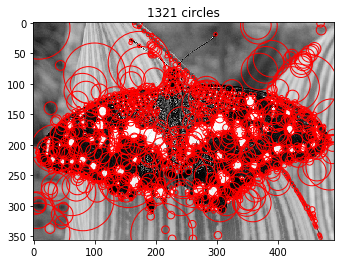

Approach 3: Difference of Gaussian, time = 5.478717803955078


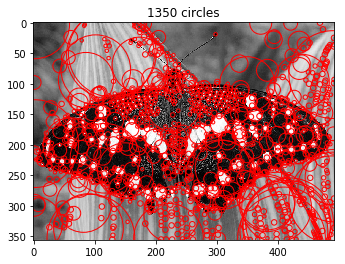

Approach 4: increase filter size with Harris filtering, time = 1.4934499263763428


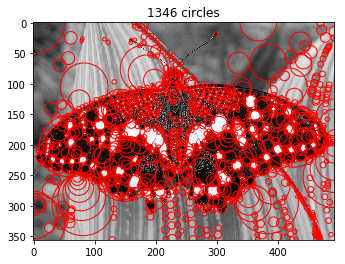

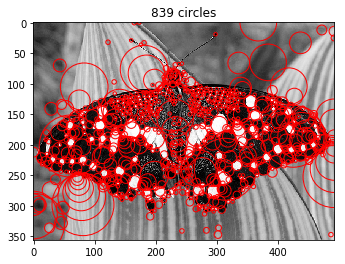

terrace.jpg
(278, 500, 3)


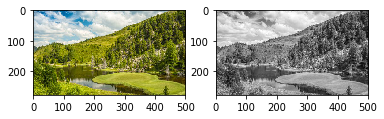

Approach 1: increase filter size, time = 6.131692171096802


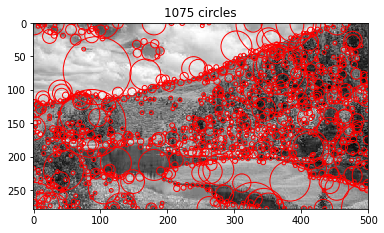

Approach 2: downsampling, time = 6.344410181045532


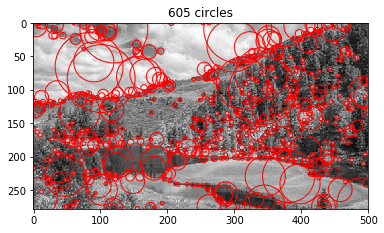

Approach 3: Difference of Gaussian, time = 4.2872419357299805


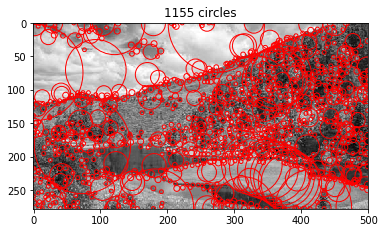

Approach 4: increase filter size with Harris filtering, time = 1.188007116317749


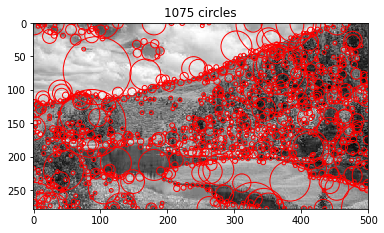

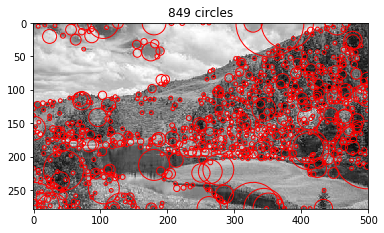

tree.jpg
(403, 400, 3)


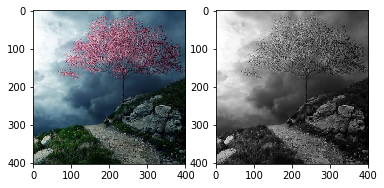

Approach 1: increase filter size, time = 7.796665668487549


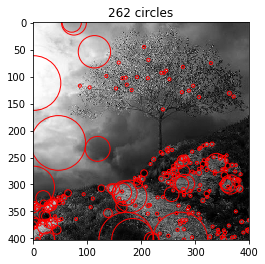

Approach 2: downsampling, time = 7.483864068984985


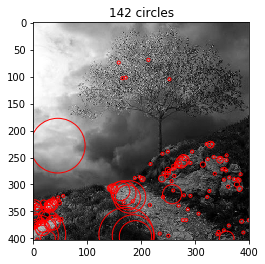

Approach 3: Difference of Gaussian, time = 5.899847984313965


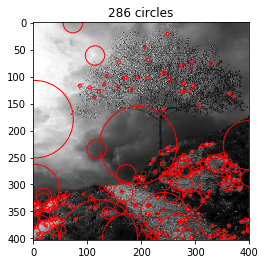

Approach 4: increase filter size with Harris filtering, time = 1.8933231830596924


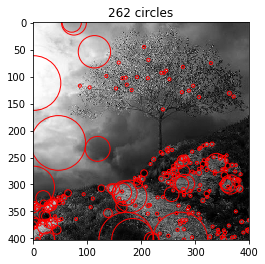

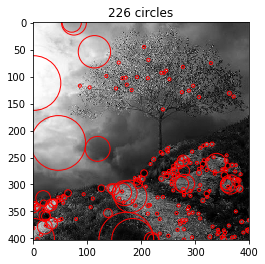

lake.jpg
(482, 626, 3)


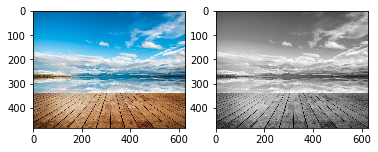

Approach 1: increase filter size, time = 13.554571866989136


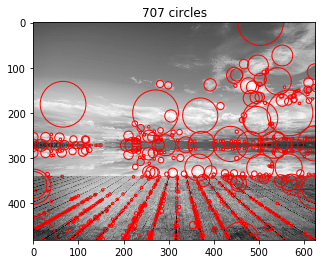

Approach 2: downsampling, time = 15.288837194442749


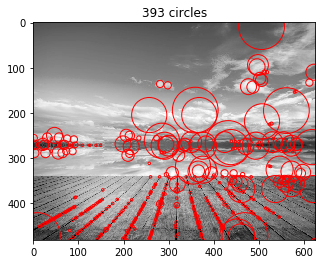

Approach 3: Difference of Gaussian, time = 10.365622997283936


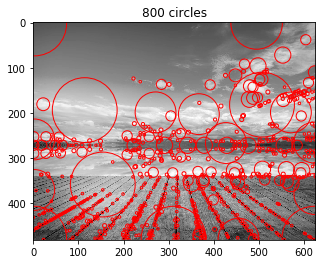

Approach 4: increase filter size with Harris filtering, time = 3.0247981548309326


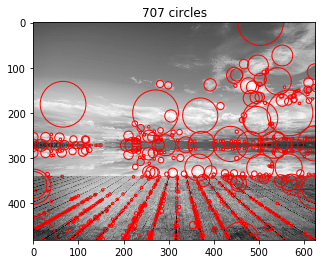

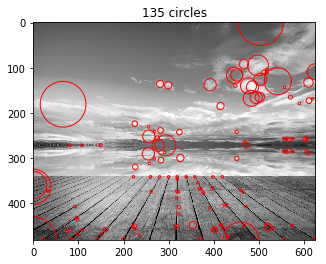

sunset.jpg
(464, 464, 3)


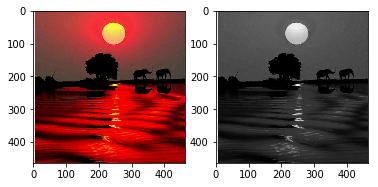

Approach 1: increase filter size, time = 9.358406066894531


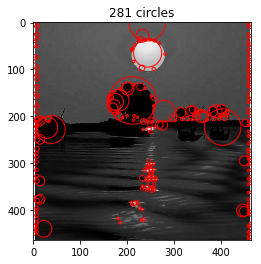

Approach 2: downsampling, time = 9.15805172920227


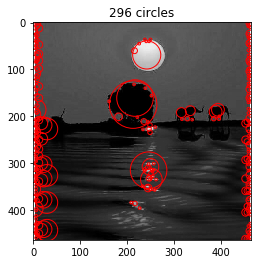

Approach 3: Difference of Gaussian, time = 6.970235347747803


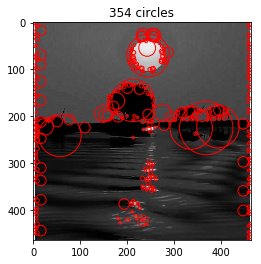

Approach 4: increase filter size with Harris filtering, time = 2.187479019165039


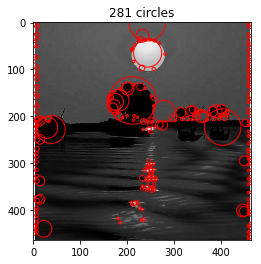

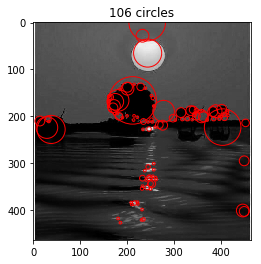

In [37]:
img_dir_path = "assignment2_images"
for filename in os.listdir(img_dir_path):
    print(filename)
    img_path = os.path.join(img_dir_path, filename)
    orig_img = io.imread(img_path)
    gray_img = color.rgb2gray(orig_img)
    print(orig_img.shape)
    
    h, w =  orig_img.shape[0], orig_img.shape[1]
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(orig_img)
    plt.subplot(122)
    plt.imshow(gray_img, cmap='gray')
    plt.show()
    
    # Approach 1: increase filter size
    Approach = "1"
    Threshold1 = 0.01
    start = time.time()
    NMS_out1 = Inc_Filt_Size(gray_img)
    print("Approach 1: increase filter size, time =", time.time() - start)
    plot_result(NMS_out1, Level, Threshold1, filename, Approach)
    
    # Approach 2: downsample image
    Approach = "2"
    Threshold2 = 0.001
    start = time.time()
    NMS_out2 = Downsample(gray_img)
    print("Approach 2: downsampling, time =", time.time() - start)
    plot_result(NMS_out2, Level, Threshold2, filename, Approach)
    
    # Approach 3: Difference of Gaussian
    Approach = "3"
    Threshold3 = 0.0004
    numOctave = 3
    numScaleImg = 4
    numDiffImg = numScaleImg - 1
    Level_DoG = numOctave * numDiffImg
    start = time.time()
    NMS_out3 = DoG(gray_img, numOctave, numScaleImg, numDiffImg)
    print("Approach 3: Difference of Gaussian, time =", time.time() - start)
    plot_result_DoG(NMS_out3, Level_DoG, numOctave, numDiffImg, Threshold3, filename, Approach)

    # Approach 4: increase filter size with Harris response filtering
    start = time.time()
    Harris_out = Harris_Filt(gray_img, NMS_out1)
    print("Approach 4: increase filter size with Harris filtering, time =", time.time() - start)
    Approach = "4_1"
    plot_result(NMS_out1, Level, Threshold1, filename, Approach)
    Approach = "4_2"
    plot_result(Harris_out, Level, Threshold1, filename, Approach)
